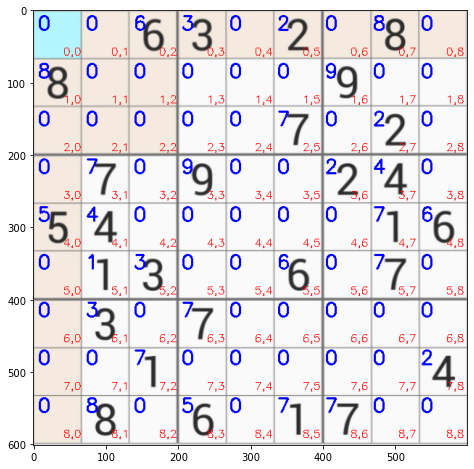

Wrong choice!!!
Wrong choice!!!
Wrong choice!!!
Wrong choice!!!
Wrong choice!!!
Wrong choice!!!
Wrong choice!!!
Wrong choice!!!
Wrong choice!!!
Wrong choice!!!
Wrong choice!!!


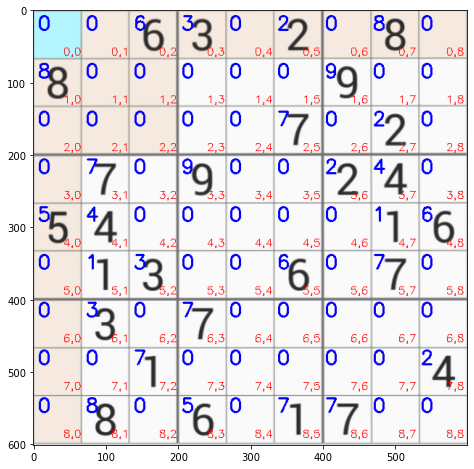

In [1]:
# Import Dependencies

import cv2
import imutils
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
from tensorflow.keras.models import load_model
import numpy as np
from Sudoku import solveSudoku
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

# Load model and image

model = load_model('model/model_mnist/')
img_path = 'sudoku images/6.png'
img_shape = [28,28]

# Reading Sudoku puzzle image

def find_puzzle(img):
    real = img.copy()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),1)
    
    thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    thresh = cv2.bitwise_not(thresh)

    cnts = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts,key=cv2.contourArea,reverse=True)

    puzzle_cnt = None

    for c in cnts:
        peri = cv2.arcLength(c,True)
        approx = cv2.approxPolyDP(c,0.02*peri,True)
        if len(approx)==4:
            puzzle_cnt=approx
            break

    if puzzle_cnt is None:
        raise Exception(("Could not find Sudoku puzzle outline.Try debugging your thresholding and contour steps."))        

    cv2.drawContours(real, [puzzle_cnt], -1, (0, 255, 0), 2)

    puzzle = four_point_transform(img, puzzle_cnt.reshape(4, 2))
    warped = four_point_transform(gray, puzzle_cnt.reshape(4, 2))

    return puzzle,warped

# 

def extract_digit(cell):
    thresh = cv2.threshold(cell,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    thresh = clear_border(thresh) #just clear the extra white pixels along the border


    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # if no contours were found than this is an empty cell
    if len(cnts) == 0:return None

    # otherwise, find the largest contour in the cell and create a mask for the contour
    c = max(cnts, key=cv2.contourArea)
    mask = np.zeros(thresh.shape, dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)

    (h, w) = thresh.shape
    percentFilled = cv2.countNonZero(mask) / float(w * h)

    # if less than 3% of the mask is filled then we are looking at noise and can safely ignore the contour
    if percentFilled < 0.03:return None

    # apply the mask to the thresholded cell
    digit = cv2.bitwise_and(thresh, thresh, mask=mask)
    kernel = np.ones((1,1),np.uint8)
    digit = cv2.dilate(digit,kernel,iterations=1)

    # return the digit to the calling function
    return digit


def display_numbers_on_board(board,puzzle):
    x = puzzle.copy()
    k = 0
    for i in range(9):
        for j in range(9):
            startX,startY,endX,endY = cell_locs[k]
            testX = int((endX - startX) * 0.1)
            testY = int((endY - startY) * -0.6)
            testX += startX
            testY += endY
            cv2.putText(x,str(board[i][j]),(testX,testY),cv2.FONT_HERSHEY_SIMPLEX,0.9,(0,0,255),2)
            cv2.putText(x,(str(i)+','+str(j)),(testX+35,testY+35),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),1)
            
            k+=1
    
    plt.figure(figsize=(12,8))
    plt.imshow(x)
    plt.show()
    return x

img = cv2.imread(img_path)
img = imutils.resize(img,width=600)

puzzle,warped = find_puzzle(img)
puzzle = imutils.resize(puzzle,width=600)
warped = imutils.resize(warped,width=600)

step_x = warped.shape[1]//9
step_y = warped.shape[0]//9

board = np.zeros(shape=(9,9),dtype='int')
cell_locs = []

for i in range(9):
    for j in range(9):
        topleftx = j*step_x
        toplefty = i*step_y
        rightendx= (j+1)*step_x
        rightendy = (i+1)*step_y
        cell = warped[toplefty:rightendy, topleftx:rightendx]
        digit = extract_digit(cell)
        if digit is not None:
            roi = cv2.resize(digit,tuple(img_shape))
            roi = roi.astype('float')/255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi,axis=0)
            pred = model.predict(roi).argmax(axis=1)[0]
            board[i,j] = pred
        cell_locs.append([topleftx,toplefty,rightendx,rightendy])

        
x = display_numbers_on_board(board,puzzle)



while 1:
    res = input('Are all numbers predicted correctly? (y/n)')
    if res=='n':
        cx,cy,ele = input('Input row no, col no, correct element of cell For eg. --> 1 2 1:  ').split()
        try:
            board[int(cx),int(cy)] = int(ele)
        except:
            print('out of range...')
        display_numbers_on_board(board,puzzle)
    elif res=='y':
        print('SOLVED!!!')
        break
    else:
        print('Wrong choice!!!')


# Solv

solved = solveSudoku(board)
x = display_numbers_on_board(board,puzzle)

cv2.imshow('solved',x)
cv2.waitKey(0)
cv2.destroyAllWindows()